# Insect detector
YOLO network trained to detect a) the presence and b) the bounding boxes of insects in images and videos.

# Step 1 Setup

## STEP 1.1 Connect the Colab notebook to Google Drive

In [0]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## STEP 1.2 Copy darknet to notebook for execution

In [0]:
# Makes a dir for darknet and move there
!mkdir /content/darknet
!mkdir /content/data
!mkdir /content/meta
!mkdir /content/temp
%cd /content/darknet

# Copy the Darkent compiled version to the VM local drive
!cp /content/gdrive/My\ Drive/darknet/bin/darknet .

# Set execution permissions to Darknet
!chmod +x ./darknet


/content/darknet
cp: cannot stat '/content/gdrive/My Drive/darknet/bin/darknet': No such file or directory
chmod: cannot access './darknet': No such file or directory


## STEP 1.3 Install Insects Client

In [0]:
%%capture
!pip install git+https://github.com/LBrinkmann/insects-client.git
import os
os.environ['INSECTS_PLATFORM_URL'] = 'http://195.201.97.57:5000'

## STEP 1.3 Copy data to notebook

In [0]:
from insectsclient import api

# load collection
labels, frame_paths = api.import_collections([36, 37, 38], '/content/data')

# create train and test dataset
data = api.create_train_obj(labels, frame_paths, train_fraction=0.8, data_dir='/content/meta', temp_dir='/content/temp') 

100% (311 of 311) |######################| Elapsed Time: 0:07:11 Time:  0:07:11


In [0]:
!tail /content/data/01-20191115202631-02.txt

2 0.1254 0.111 0.0345 0.0779
2 0.1207 0.82 0.029999999999999985 0.054400000000000004
2 0.9054 0.9561 0.02970000000000006 0.06779999999999997
2 0.011699999999999999 0.31579999999999997 0.0218 0.08029999999999998


In [0]:
!tail /content/meta/obj.names

locusta migratoria
schistocerca gregaria
acheta domesticus


## STEP 1.4 Define utility functions

In [0]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

## STEP 2.1 Check if everything is ready for training

In [0]:
# all models
!ls '/content/gdrive/My Drive/darknet/models'

full
insects_yolov3_4000_crickets200.weights
insects_yolov3_final_fulldataset.weights
insects_yolov3-tiny_4000_crickets200.weights
insects_yolov3-tiny_final_fulldataset.weights
insects_yolov3-tiny_final_smalldataset.weights
README.md
tiny


In [0]:
# select model and weights

DATA='/content/meta/obj.data'
# MODEL="/content/gdrive/My\ Drive/darknet/cfg/insects_yolov3-tiny.cfg"
# WEIGHTS='/content/gdrive/My\ Drive/darknet/models/insects_yolov3-tiny_final_fulldataset.weights'

MODEL="/content/gdrive/My\ Drive/darknet/cfg/insects_yolov3.cfg"
WEIGHTS='/content/gdrive/My\ Drive/darknet/models/insects_yolov3_4000_crickets200.weights'

# '/content/gdrive/My Drive/darknet/backup/insects/insects_yolov3-tiny_last.weights' tiny insect weights
# '/content/gdrive/My Drive/darknet/backup/insects/insects_yolov3_4000.weights' full insect weights

#  '/content/gdrive/My Drive/darknet/cfg/insects_yolov3.cfg' full yolo
#  '/content/gdrive/My Drive/darknet/weights/darknet53.conv.74' full yolo weights


In [0]:
# check if all files exists in the correct place
%cd /content/darknet/

!ls darknet

!ls $WEIGHTS  # pre-trained start weights
!ls $MODEL  # network configuration file
!ls $DATA  # data and classification problem configuration file
!ls '/content/meta/obj.names'  # class name
!ls '/content/meta/test.txt'  # list of test images
!ls '/content/meta/train.txt'  # list of train images
!ls '/content/temp'  # where to save the check-points and winal weights
!head -n2 '/content/meta/test.txt'
!head -n2 '/content/meta/train.txt'


/content/darknet
darknet
'/content/gdrive/My Drive/darknet/models/insects_yolov3_4000_crickets200.weights'
'/content/gdrive/My Drive/darknet/cfg/insects_yolov3.cfg'
/content/meta/obj.data
/content/meta/obj.names
/content/meta/test.txt
/content/meta/train.txt
/content/data/2020-01-15-12-08-02-00.jpg
/content/data/2020-01-16-18-06-35-00.jpg
/content/data/2020-01-17-12-20-58-00.jpg
/content/data/01-20191115202513-00.jpg


In [0]:
!tail '/content/meta/obj.data'

tail: cannot open '/content/meta/obj.data' for reading: No such file or directory


## STEP 2.2 Train network

In [0]:
# train yolo
!./darknet detector train $DATA $MODEL -dont_show -map

 Prepare additional network for mAP calculation...
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52

## STEP 3.1 Evaluate on single image

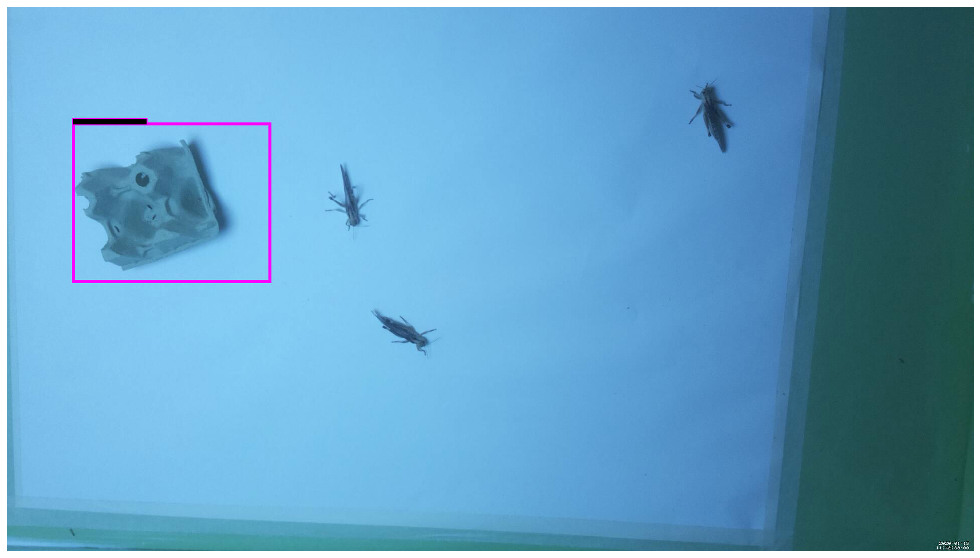

In [0]:
# copy required names files (path seems to be hard-coded into executable)
# tryout resulting network (insects)
!./darknet detector test $DATA $MODEL $WEIGHTS \
    "/content/data/2020-01-15-11-42-39-00.jpg"  \
    -thresh 0.01 --dont-show > /dev/null 2>&1

# Show the result using the helper imgShow()
imShow('predictions.jpg')

## STEP 3.2 Evaluate on comple validation set

In [0]:
!./darknet detector valid $DATA $MODEL $WEIGHTS

results: Using default 'results'
layer     filters    size              input                output
   0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16 0.150 BF
   1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16 0.003 BF
   2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32 0.399 BF
   3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32 0.001 BF
   4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64 0.399 BF
   5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64 0.001 BF
   6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128 0.399 BF
   7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128 0.000 BF
   8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256 0.399 BF
   9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256 0.000 BF
  10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512 0.399 BF
  11 max          2 x 2 / 1    13 x  13 x 

In [0]:
# evaluate trained network
!./darknet detector map $DATA $MODEL $WEIGHTS \
                        -points 0  # -iou_thresh 0.25 -thresh 0.5

layer     filters    size              input                output
   0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16 0.150 BF
   1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16 0.003 BF
   2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32 0.399 BF
   3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32 0.001 BF
   4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64 0.399 BF
   5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64 0.001 BF
   6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128 0.399 BF
   7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128 0.000 BF
   8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256 0.399 BF
   9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256 0.000 BF
  10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512 0.399 BF
  11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512 0.000 

# Tentative results

## Crickets200
aka 160 train and 40 test images, all from the self-recorded cricket images. Most images contain multiple crickets: Roughly 300 cricket boxes in test/validation and 1.200 cricket boxes in training set.


### Full YOLO
 Best results around 4.000th iteration. More than 10% points over the tiny YOLO best result.

 #### 1000
 for thresh = 0.25, precision = 0.87, recall = 0.73, F1-score = 0.80 
 for thresh = 0.25, TP = 191, FP = 28, FN = 70, average IoU = 61.83 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.822034, or 82.20 % 

 #### 2000
 for thresh = 0.25, precision = 0.85, recall = 0.86, F1-score = 0.85 
 for thresh = 0.25, TP = 224, FP = 40, FN = 37, average IoU = 60.77 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.808896, or 80.89 % 

 #### 3000
 for thresh = 0.25, precision = 0.86, recall = 0.87, F1-score = 0.87 
 for thresh = 0.25, TP = 227, FP = 36, FN = 34, average IoU = 61.16 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.857315, or 85.73 % 

 #### 4000
 for thresh = 0.25, precision = 0.90, recall = 0.89, F1-score = 0.90 
 for thresh = 0.25, TP = 233, FP = 25, FN = 28, average IoU = 64.90 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.868543, or 86.85 % 

 #### 5000
 for thresh = 0.25, precision = 0.89, recall = 0.89, F1-score = 0.89 
 for thresh = 0.25, TP = 232, FP = 30, FN = 29, average IoU = 63.81 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.857123, or 85.71 % 


### Tiny YOLO
Clearly the validation set f1-score stabilizes around the 3.000-4.000th batch iteration at somewhat above 0.75. This is a very promising values.

- With some more training images, we might achieve an even higher validation set score.
- Using the full YOLO net, we can expect to reach a higher validation set score.
- Training more than 4.000 batch iterations does not seem to add additional value.

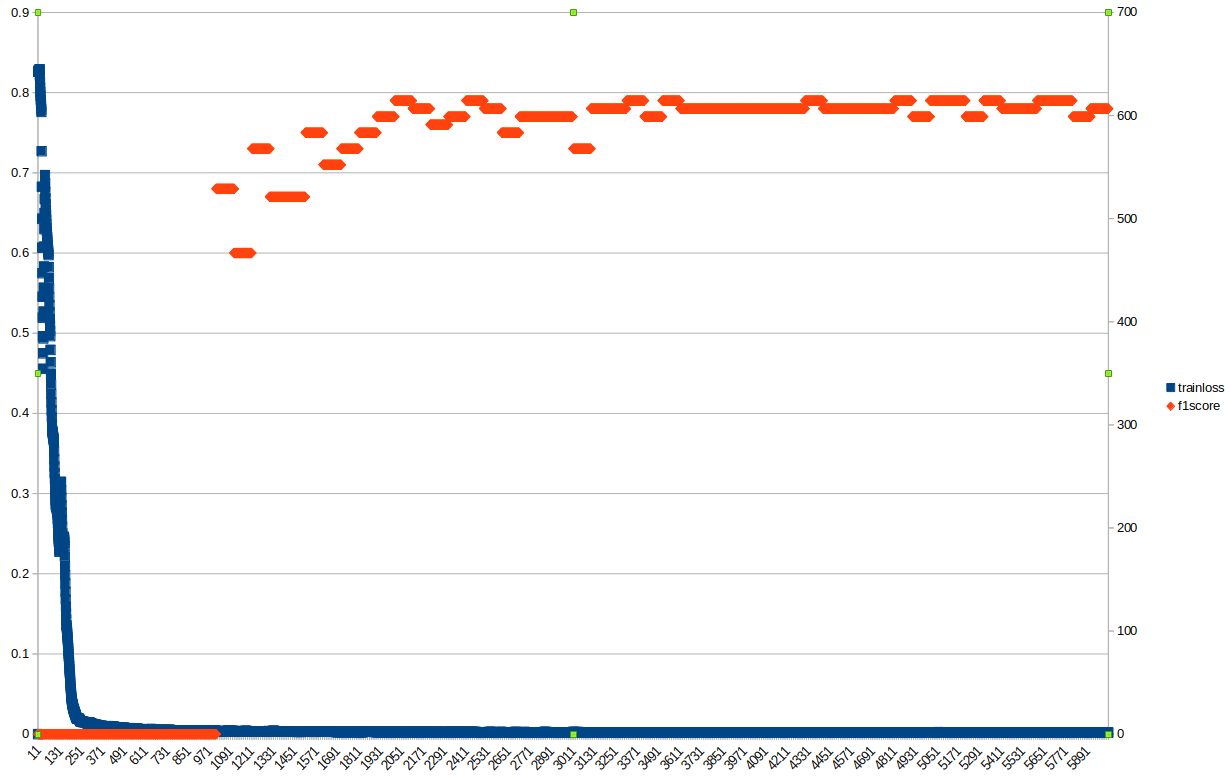

 #### 4000
 for thresh = 0.25, precision = 0.79, recall = 0.78, F1-score = 0.78 
 for thresh = 0.25, TP = 203, FP = 55, FN = 58, average IoU = 55.10 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.724331, or 72.43 % 

## Crickets100
aka 77 train and 20 test images, all from the self-recorded cricket images. Most images contain multiple crickets.

### Tiny YOLO
We observe an training improvement up to 2k batch iterations. After that, the system becomes unstable, increasing and decreasing performance on the validation set in waves. This is likely due to the small number of training and validation images.

Considering that we only had 77 training images, the results are very promising.

 #### 1000
 for thresh = 0.25, precision = 0.53, recall = 0.44, F1-score = 0.48 
 for thresh = 0.25, TP = 77, FP = 67, FN = 97, average IoU = 32.99 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.314299, or 31.43 % 

 #### 2000
 for thresh = 0.25, precision = 0.66, recall = 0.52, F1-score = 0.59 
 for thresh = 0.25, TP = 91, FP = 46, FN = 83, average IoU = 43.78 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.449727, or 44.97 % 
 
 #### 3000
 or thresh = 0.25, precision = 0.56, recall = 0.43, F1-score = 0.49 
 for thresh = 0.25, TP = 74, FP = 57, FN = 100, average IoU = 34.90 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.321900, or 32.19 %




## Complete trainset
aka 18360 train and 4590 test images, all from the _coift_, _stonefly9_, and _IP120_ datasets.

### Tiny YOLO

The results are promising. The evaluation metrics increase up till 4k batch iterations, afterwards they seem to fluctuate lightly. The perfect number of batch iterations depends on target metric.

#### 1000
 for thresh = 0.25, precision = 0.89, recall = 0.33, F1-score = 0.49 
 for thresh = 0.25, TP = 1495, FP = 179, FN = 2992, average IoU = 63.14 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.767658, or 76.77 % 
 
#### 2000
 for thresh = 0.25, precision = 0.89, recall = 0.44, F1-score = 0.59 
 for thresh = 0.25, TP = 1993, FP = 246, FN = 2494, average IoU = 64.46 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.790170, or 79.02 % 

#### 3000
 for thresh = 0.25, precision = 0.93, recall = 0.72, F1-score = 0.81 
 for thresh = 0.25, TP = 3214, FP = 228, FN = 1273, average IoU = 70.46 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.907326, or 90.73 % 

#### 4000
 for thresh = 0.25, precision = 0.93, recall = 0.80, F1-score = 0.86 
 for thresh = 0.25, TP = 3597, FP = 278, FN = 890, average IoU = 69.85 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.914455, or 91.45 % 

#### 5000
 for thresh = 0.25, precision = 0.93, recall = 0.78, F1-score = 0.85 
 for thresh = 0.25, TP = 3491, FP = 253, FN = 996, average IoU = 70.34 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.913551, or 91.36 % 

#### 6000
 for thresh = 0.25, precision = 0.92, recall = 0.82, F1-score = 0.87 
 for thresh = 0.25, TP = 3678, FP = 303, FN = 809, average IoU = 69.49 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.916284, or 91.63 % 


### Fully YOLO

The results are better than for tiny yolor and still increasing to 4000 batch iterations.

 #### 1000
 for thresh = 0.25, precision = 0.88, recall = 0.75, F1-score = 0.81 
 for thresh = 0.25, TP = 3381, FP = 480, FN = 1106, average IoU = 62.26 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.846892, or 84.69 % 
 
 #### 2000
  for thresh = 0.25, precision = 0.92, recall = 0.90, F1-score = 0.91 
  for thresh = 0.25, TP = 4041, FP = 357, FN = 446, average IoU = 68.19 % 

  IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
  mean average precision (mAP@0.50) = 0.920058, or 92.01 % 

 #### 3000
 for thresh = 0.25, precision = 0.93, recall = 0.91, F1-score = 0.92 
 for thresh = 0.25, TP = 4098, FP = 306, FN = 389, average IoU = 72.76 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.943184, or 94.32 % 

 #### 4000
 for thresh = 0.25, precision = 0.94, recall = 0.93, F1-score = 0.93 
 for thresh = 0.25, TP = 4176, FP = 282, FN = 311, average IoU = 74.32 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.943718, or 94.37 % 

 #### 6000
 for thresh = 0.25, precision = 0.94, recall = 0.93, F1-score = 0.93 
 for thresh = 0.25, TP = 4153, FP = 282, FN = 334, average IoU = 74.00 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.946355, or 94.64 % 
 

## Small trainset
aka 103 train and 35 test images, all from the _coift_ dataset.

### Tiny YOLO

#### 1000
 for thresh = 0.25, precision = 0.82, recall = 0.56, F1-score = 0.67 
 for thresh = 0.25, TP = 14, FP = 3, FN = 11, average IoU = 53.61 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.777251, or 77.73 % 
 
#### 2000
 for thresh = 0.25, precision = 0.73, recall = 0.44, F1-score = 0.55 
 for thresh = 0.25, TP = 11, FP = 4, FN = 14, average IoU = 51.18 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.718978, or 71.90 % 

#### 3000
 for thresh = 0.25, precision = 0.83, recall = 0.60, F1-score = 0.70 
 for thresh = 0.25, TP = 15, FP = 3, FN = 10, average IoU = 58.99 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.774400, or 77.44 % 

#### 4000
 for thresh = 0.25, precision = 0.84, recall = 0.64, F1-score = 0.73 
 for thresh = 0.25, TP = 16, FP = 3, FN = 9, average IoU = 61.21 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.786036, or 78.60 % 



In [0]:
!./darknet detector test '/content/meta/obj.data' \
                        "/content/gdrive/My Drive/darknet/cfg/insects_yolov3-tiny.cfg" \
                        '/content/gdrive/My Drive/darknet/weights/yolov3-tiny.conv.15' \
                         -dont_show -save_labels < '/content/gdrive/My Drive/darknet/data/insects/train.txt'

Streaming output truncated to the last 5000 lines.
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 100%
insect: 38%
insect: 33%
insect: 37%
insect: 26%
insect: 47%
insect: 52%
insect: 31%
insect: 26%
insect: 45%
insect: 37%
insect: 44%
insect: 57%
insect: 34%
insect: 34%
insect: 34%
insect: 30%
insect: 26%
insect: 43%
insect: 32%
insect: 30%
insect: 40%
insect: 38%
insect: 35%
insect: 35%
insect: 25%
insect: 31%
insect: 36%
insect: 31%
insect: 30%
insect: 26%
insect: 26%
insect: 27%
insect: 34%
insect: 43%
insect: 